In [105]:
import pandas as pd
import numpy as np
import math

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [25]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

In [26]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

## Variable

In [27]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [108]:
def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)

def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

def mse(actual, predicted):
    return mean_squared_error(actual, predicted)

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def model_results(actual, predicted, rowcount, featurecount):
    print('r-squared: ', round(r2(actual, predicted),4))
    print('adj r-squared', round(adjr2(actual,predicted,rowcount, featurecount),4))
    print('mse: ', round(mse(actual, predicted),4))
    print('rmse: ', round(rmse(actual, predicted),4))
    print('rmse: ', eval_measures.rmse(actual,predicted,axis=0))

In [29]:
def load_taylor():
    
    gdpc1_df = pd.read_csv('./data/GDPC1.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpc1_df:', gdpc1_df.shape)
    gdppot_df = pd.read_csv('./data/GDPPOT.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdppot_df:', gdppot_df.shape)
    gdpdef_df = pd.read_csv('./data/GDPDEF.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpdef_df:', gdpdef_df.shape)
    fed_df = pd.read_csv('./data/FEDFUNDS.csv', parse_dates=['observation_date'], skiprows=10)
    print('fed_df:', fed_df.shape)
    
    
    taylor_df = gdpc1_df.merge(gdppot_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(gdpdef_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(fed_df, how='outer', left_on='observation_date', right_on='observation_date')

    taylor_df.dropna(inplace=True)
    taylor_df
    
    
    #taylor_df = pd.DataFrame()
    taylor_df['ffef_tr'] = taylor_df['GDPDEF_PC1'] + 2    \
                            +0.5*(taylor_df['GDPDEF_PC1'] - 2)    \
                            +0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

    taylor_df['gap_inf'] = 0.5*(taylor_df['GDPDEF_PC1'] - 2) 
    taylor_df['gap_gdp'] = 0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

    taylor_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    taylor_df = taylor_df.set_index('DATE')
    
    return taylor_df



def load_misery():
    
    t_df = pdr.DataReader(['FEDFUNDS','CPIAUCSL', 'UNRATE'], data_source, start_date)
    t_df.dropna(inplace=True)
    print('t_df:', t_df.shape)

    u_df = pd.read_csv('./data/CPIAUCSL.csv', parse_dates=['observation_date'], skiprows=10)
    u_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    u_df.set_index('DATE', inplace=True)
    print('u_df:', u_df.shape)

    misery_df = pd.merge(t_df,u_df, left_index=True, right_index=True )
    misery_df['m_index'] = misery_df['CPIAUCSL_CH1'] + misery_df['UNRATE']
    print('misery_df:', misery_df.shape)  
    
    return misery_df



def time_split(df):
    t_df = df.copy()

    # Split Data
    splt_index = round(df.shape[0] * 0.8)
    train_df = t_df[:splt_index]
    print('train_df: ' , train_df.shape)

    end_index = splt_index - t_df.shape[0]
    test_df = t_df[end_index:]
    print('test_df: ' , test_df.shape)
    
    return train_df, test_df

# Taylor Rule
The FRED® Blog
https://fredblog.stlouisfed.org/2014/04/the-taylor-rule/

This graph shows in blue the Taylor Rule, which is a simple formula that John Taylor devised to guide policymakers. It calculates what the federal funds rate should be, as a function of the output gap and current inflation. Here, we measure the output gap as the difference between potential output (published by the Congressional Budget Office) and real GDP. Inflation is measured by changes in the CPI, and we use a target inflation rate of 2%. We also assume a steady-state real interest rate of 2%. These are a lot of assumptions, and you are welcome to change them on the graph by playing around with the formula to see how the Taylor Rule matches up with the effective federal funds rate. To read up on the Taylor Rule, see the original article or an article by former St. Louis Fed president William Poole.

How this graph was created: To create a new series from several series, first add the series by modifying the existing series in the “Graph” tab. Once you have assembled them all, expand the series section in the same tab and “create your own transformation.” Finally, as the axis legend has become unwieldy, remove it by checking off the mark in the graph tab.

Suggested by: Christian Zimmermann

Update: A previous version did not multiply the output gap by 100.

View on FRED, series used in this post: FEDFUNDS, GDPC1, GDPDEF, GDPPOT

# Fred Calculations

In [30]:
base_df = pd.read_csv('./data/fred.csv', parse_dates=['fund_date','taylor_date'])
base1_df = base_df[['fund_date','FEDFUNDS']].dropna().copy()
base1_df.sort_values(by='fund_date', inplace = True)
base2_df = base_df[['taylor_date','GDPPOT_GDPC1_GDPDEF_PC1']].copy()
base2_df.sort_values(by='taylor_date', inplace = True)
base2_df.dropna(inplace=True)

In [31]:
base1_df

,fund_date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
826,2023-05-01,5.06
827,2023-06-01,5.08
828,2023-07-01,5.12
829,2023-08-01,5.33


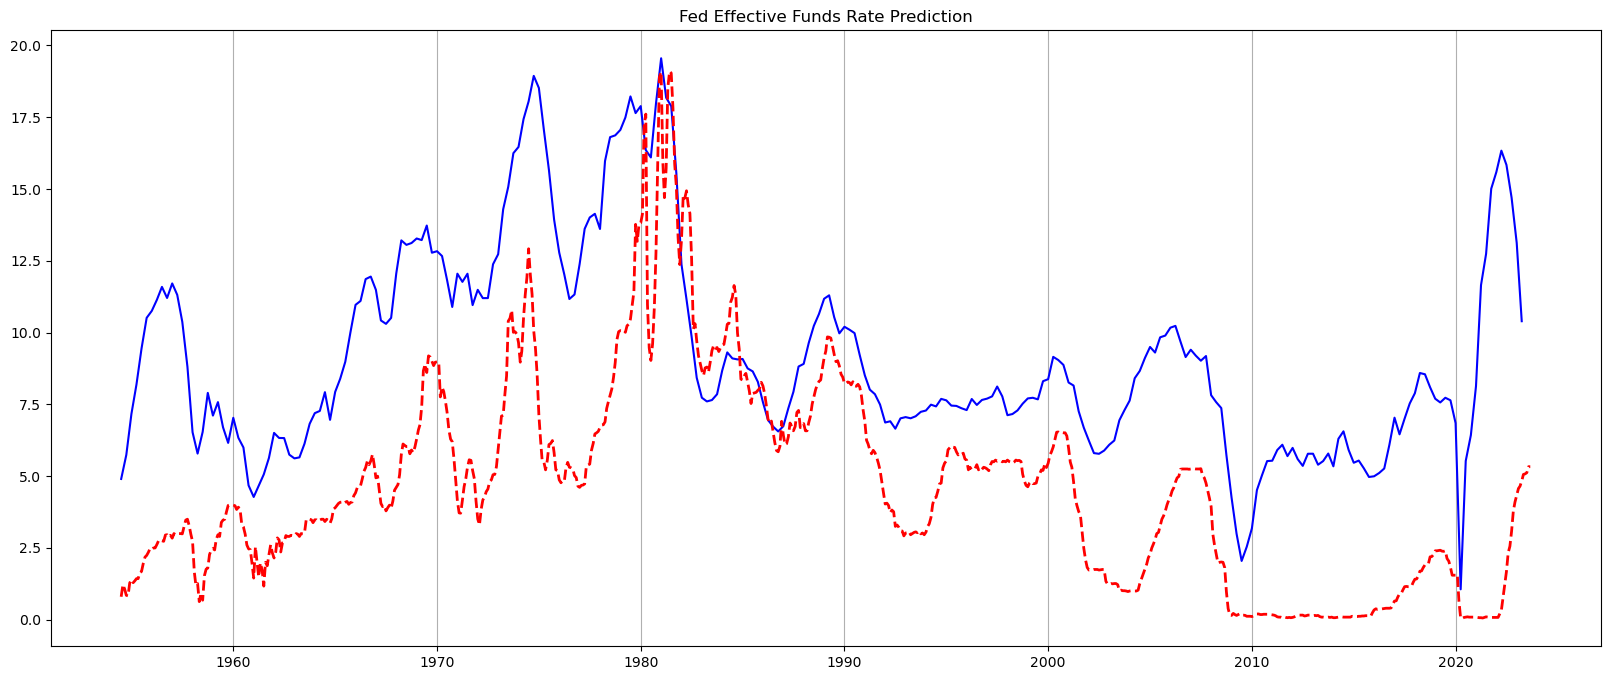

In [32]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(base2_df['taylor_date'], base2_df['GDPPOT_GDPC1_GDPDEF_PC1'], 'blue')
ax.plot(base1_df['fund_date'], base1_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

## Calculation 1

In [33]:
taylor_df = load_taylor()
taylor_df.head()

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp
DATE,,,,,,,
1954-07-01,2880.482,2727.099666,0.7,0.80,4.862188,-0.65,2.812188
1954-10-01,2936.852,2743.726730,0.8,0.85,5.719397,-0.60,3.519397
1955-01-01,3020.746,2760.136280,1.0,1.39,7.220957,-0.50,4.720957
1955-04-01,3069.910,2777.950765,1.3,1.43,8.204939,-0.35,5.254939
1955-07-01,3111.379,2795.471543,1.9,1.68,9.500343,-0.05,5.650343


In [34]:
model_results(taylor_df['FEDFUNDS'], taylor_df['ffef_tr'], taylor_df.shape[0], 2 )

r-squared:  -1.2856
adj r-squared -1.2939
mse:  30.4347
rmse:  5.5168


long_df: (1104, 3)


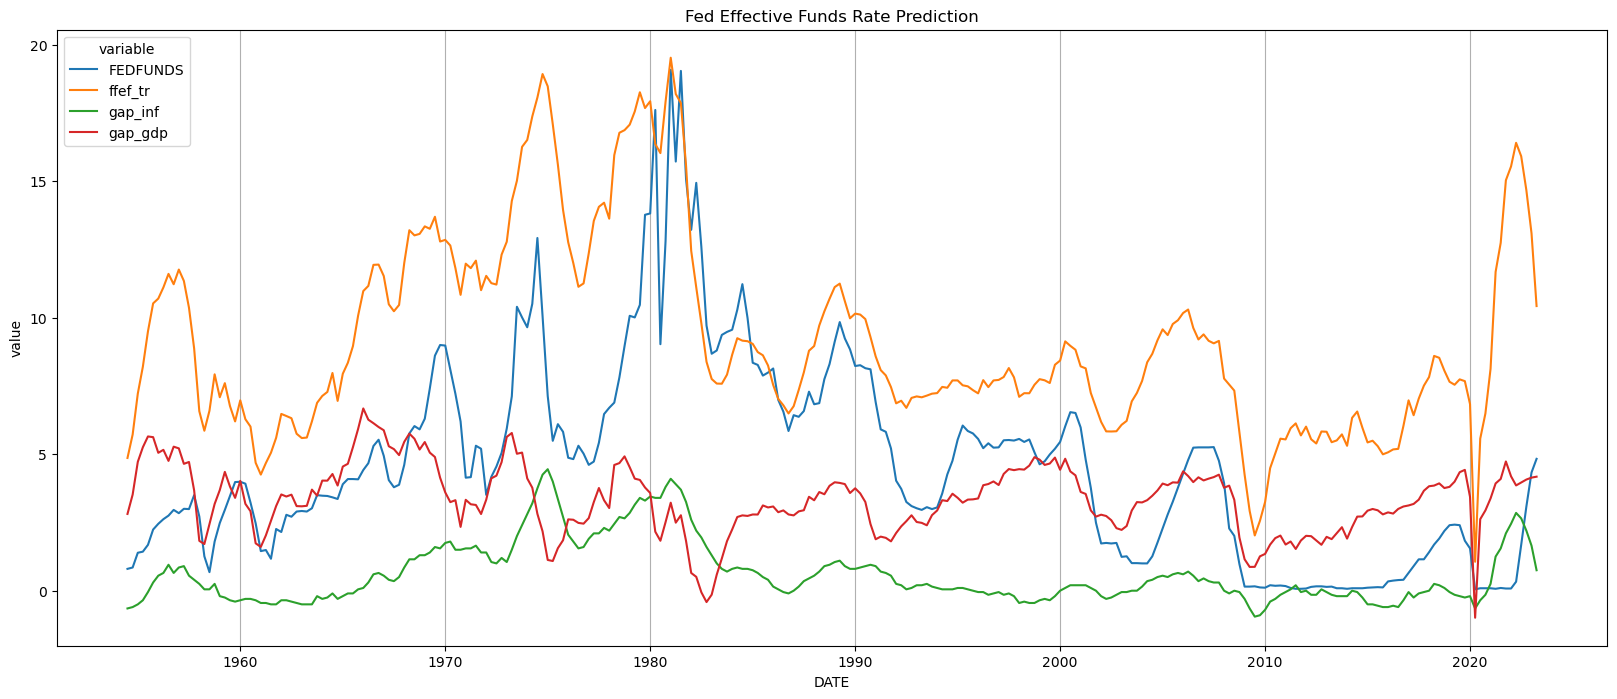

In [35]:
# Long 
long_df = taylor_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','FEDFUNDS','ffef_tr','gap_inf','gap_gdp']].melt(id_vars=['DATE'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
#ax.plot(long_df['observation_date'], long_df['value'], color='variable')
sns.lineplot(x = 'DATE', y = 'value', data=long_df, hue='variable')

ax.set(title='Fed Effective Funds Rate Prediction');

long_df: (828, 3)


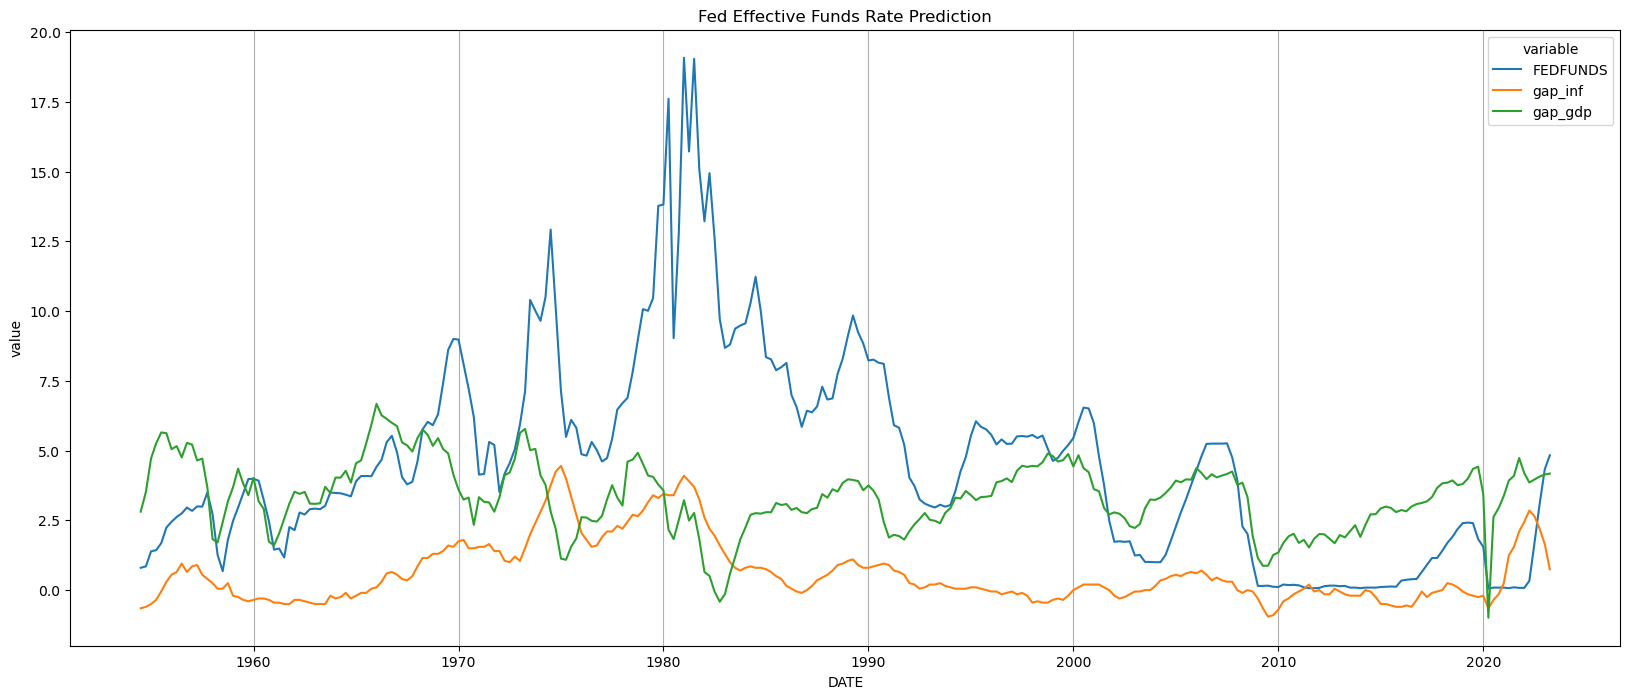

In [36]:
# Long 
long_df = taylor_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','FEDFUNDS','gap_inf','gap_gdp']].melt(id_vars=['DATE'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
#ax.plot(long_df['observation_date'], long_df['value'], color='variable')
sns.lineplot(x = 'DATE', y = 'value', data=long_df, hue='variable')

ax.set(title='Fed Effective Funds Rate Prediction');

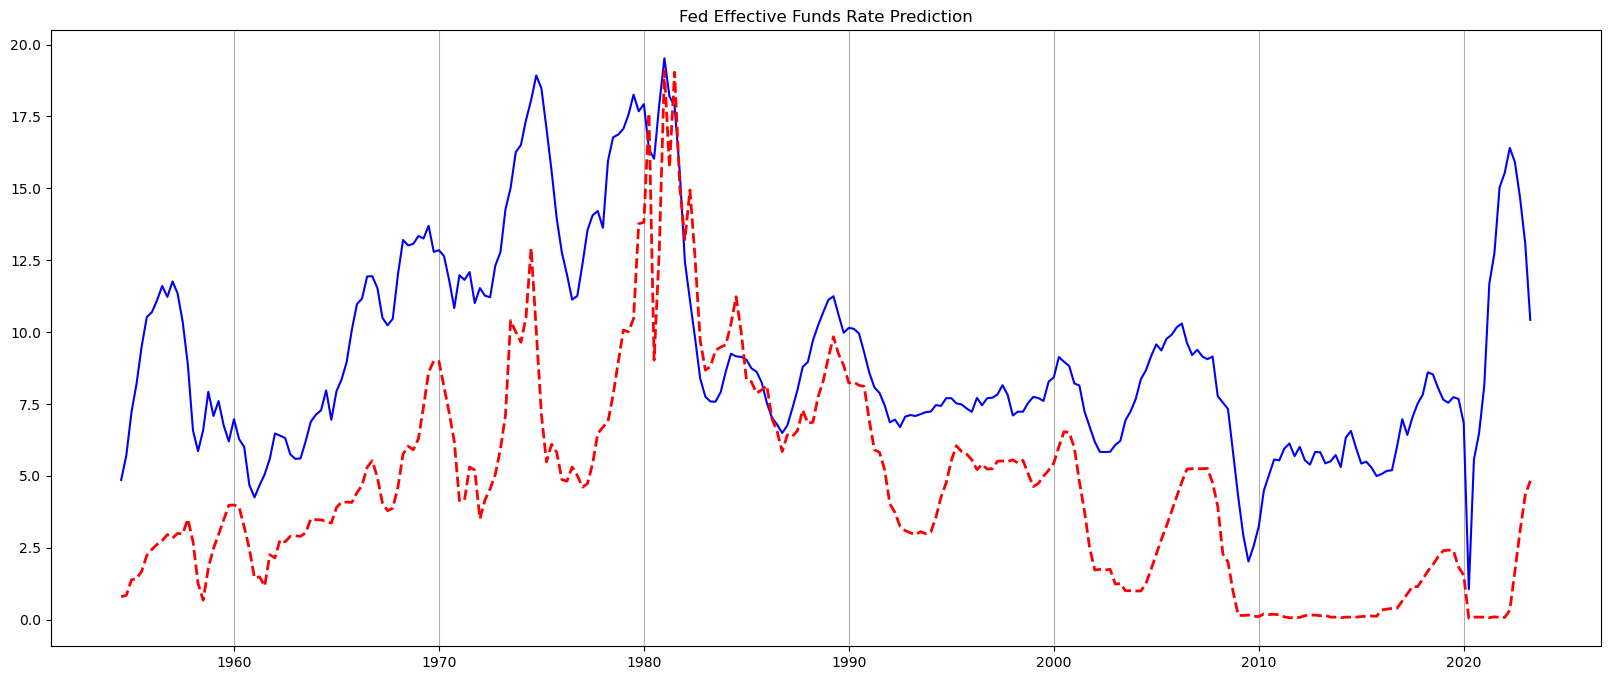

In [37]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'blue')
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

# Misery Index

In [38]:
misery_df = load_misery()

t_df: (831, 3)
u_df: (909, 1)
misery_df: (831, 5)


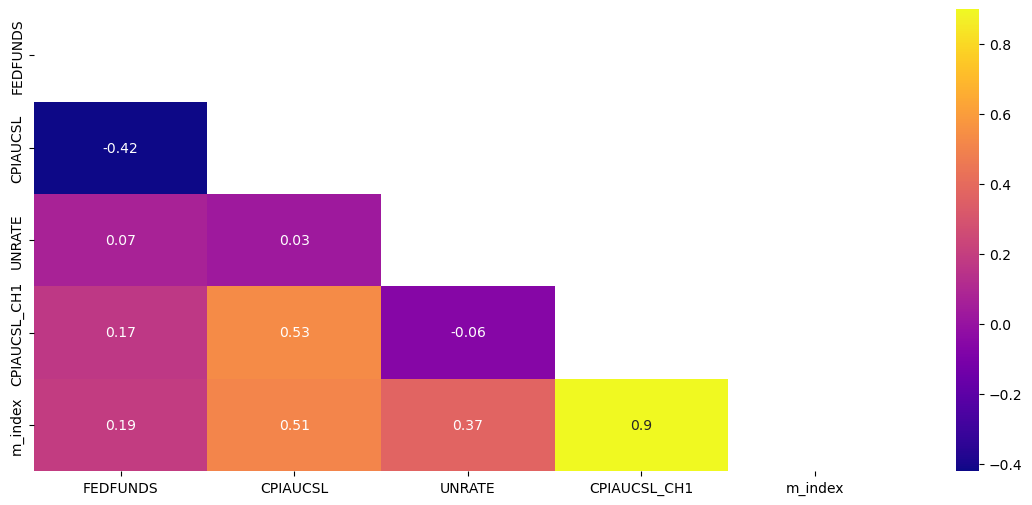

In [39]:
plt.figure(figsize=(14,6))
mask = np.zeros_like(misery_df.corr())
mask[np.triu_indices_from(mask)] = True
_p = sns.heatmap(misery_df.corr().round(2), annot=True, mask=mask, cmap="plasma")

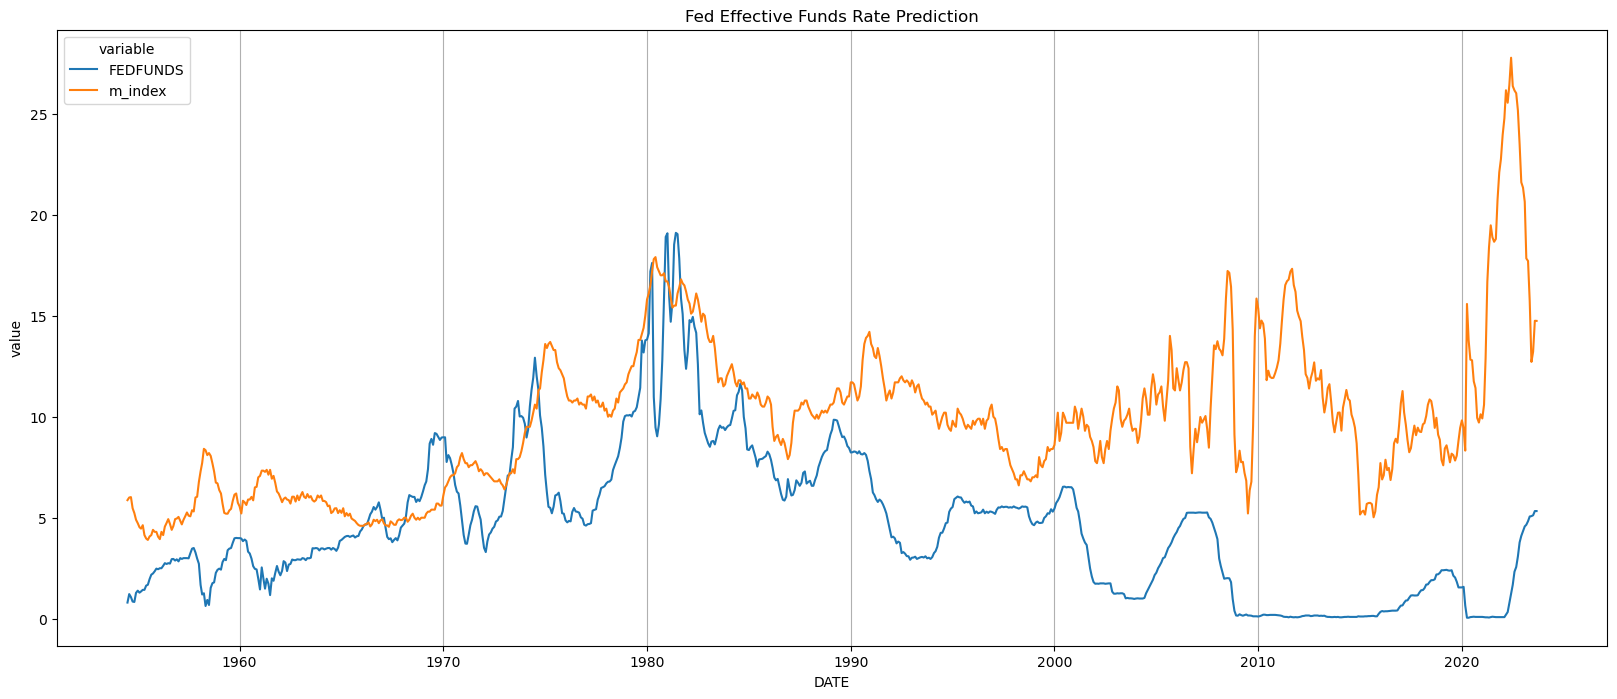

In [40]:
long_df = misery_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','FEDFUNDS','m_index']].melt(id_vars=['DATE'])

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
sns.lineplot(data=long_df, x = 'DATE', y = 'value', hue='variable')
#ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

# Taylor Rule

<b> Variables </b>
- nominal funds rate - FEDFUNDS
- real interest rate - REAINTRATREARAT1MO
- inflation - CPIAUCSL
- real gpd - real
- target = 0.02

#  Federal Reserve Economic Data Service
data_source = 'fred'
unemployment_rate_code = 'UNRATE'
cpi_code = 'CORESTICKM157SFRBATL'
real_rate_code = 'REAINTRATREARAT1MO'

cpi_urban = 'CPIAUCSL'
inf_10y = 'T10YIEM'
ff_rate_code = 'EFFR'

#GDP GAP
p_gdp = 'GDPPOT'

In [41]:
t1_df = pdr.DataReader(['FEDFUNDS','REAINTRATREARAT1MO','CORESTICKM157SFRBATL','GDPC1','GDPPOT'], data_source, start_date)
#t1_df.dropna(inplace=True)
print('t1_df:', t1_df.shape)
t1_df.head(5)

t1_df: (862, 5)


,FEDFUNDS,REAINTRATREARAT1MO,CORESTICKM157SFRBATL,GDPC1,GDPPOT
DATE,,,,,
1947-01-01,NaN,NaN,NaN,2182.681,NaN
1947-04-01,NaN,NaN,NaN,2176.892,NaN
1947-07-01,NaN,NaN,NaN,2172.432,NaN
1947-10-01,NaN,NaN,NaN,2206.452,NaN
1948-01-01,NaN,NaN,NaN,2239.682,NaN


In [42]:
t2_df = pd.read_csv('./data/Holston_Laubach_Williams_real_time_estimates.csv', parse_dates=['Date'], skiprows=5)
t2_df.set_index('Date', inplace=True)
print('t2_df:', t2_df.shape)
t2_df.head(5)

t2_df: (250, 3)


,Growth_g,Real_Interest_Rate,Output_Gap
Date,,,
1961-01-01,4.828759,5.493491,-3.755573
1961-04-01,4.989798,5.682399,-3.407557
1961-07-01,4.923091,5.609036,-2.640213
1961-10-01,4.910719,5.592011,-1.931028
1962-01-01,4.767864,5.431519,-1.116593


In [43]:
f1_df = t1_df.merge(t2_df, how='outer', left_index=True, right_index=True)
f1_df.dropna(inplace=True)
f1_df.index.rename('DATE', inplace=True)
f1_df.head()

,FEDFUNDS,REAINTRATREARAT1MO,CORESTICKM157SFRBATL,GDPC1,GDPPOT,Growth_g,Real_Interest_Rate,Output_Gap
DATE,,,,,,,,
1982-01-01,13.22,2.464018,0.36879,7295.631,7202.119830,2.956000,2.966393,-3.849021
1982-04-01,14.94,8.803434,0.90752,7328.912,7255.183995,3.080303,3.046039,-4.753866
1982-07-01,12.59,7.161898,0.56243,7300.896,7309.422617,2.918558,2.946979,-5.089924
1982-10-01,9.71,2.752972,0.29105,7303.817,7365.185870,2.863820,2.839540,-5.658898
1983-01-01,8.68,4.469162,0.53839,7400.066,7421.653951,2.990278,2.990787,-5.548596


In [44]:
target_inf = 2
alpha = 0.5
beta = 0.5

In [45]:
f1_df['gap_gdp'] = alpha * (f1_df['GDPC1'] - f1_df['GDPPOT']) / f1_df['GDPPOT'] * 100
f1_df['gap_inf'] = beta * (f1_df['CORESTICKM157SFRBATL'] - target_inf)

f1_df['ffef_tr'] = f1_df['Real_Interest_Rate']  \
                        + f1_df['CORESTICKM157SFRBATL']  \
                        + f1_df['gap_gdp']  \
                        + f1_df['gap_inf']

f1_df.head()

,FEDFUNDS,REAINTRATREARAT1MO,CORESTICKM157SFRBATL,GDPC1,GDPPOT,Growth_g,Real_Interest_Rate,Output_Gap,gap_gdp,gap_inf,ffef_tr
DATE,,,,,,,,,,,
1982-01-01,13.22,2.464018,0.36879,7295.631,7202.119830,2.956000,2.966393,-3.849021,0.649192,-0.815605,3.168770
1982-04-01,14.94,8.803434,0.90752,7328.912,7255.183995,3.080303,3.046039,-4.753866,0.508106,-0.546240,3.915425
1982-07-01,12.59,7.161898,0.56243,7300.896,7309.422617,2.918558,2.946979,-5.089924,-0.058326,-0.718785,2.732298
1982-10-01,9.71,2.752972,0.29105,7303.817,7365.185870,2.863820,2.839540,-5.658898,-0.416615,-0.854475,1.859500
1983-01-01,8.68,4.469162,0.53839,7400.066,7421.653951,2.990278,2.990787,-5.548596,-0.145439,-0.730805,2.652933


In [46]:
model_results(f1_df['FEDFUNDS'], f1_df['ffef_tr'], f1_df.shape[0], 2 )

r-squared:  0.2886
adj r-squared 0.2843
mse:  7.8474
rmse:  2.8013


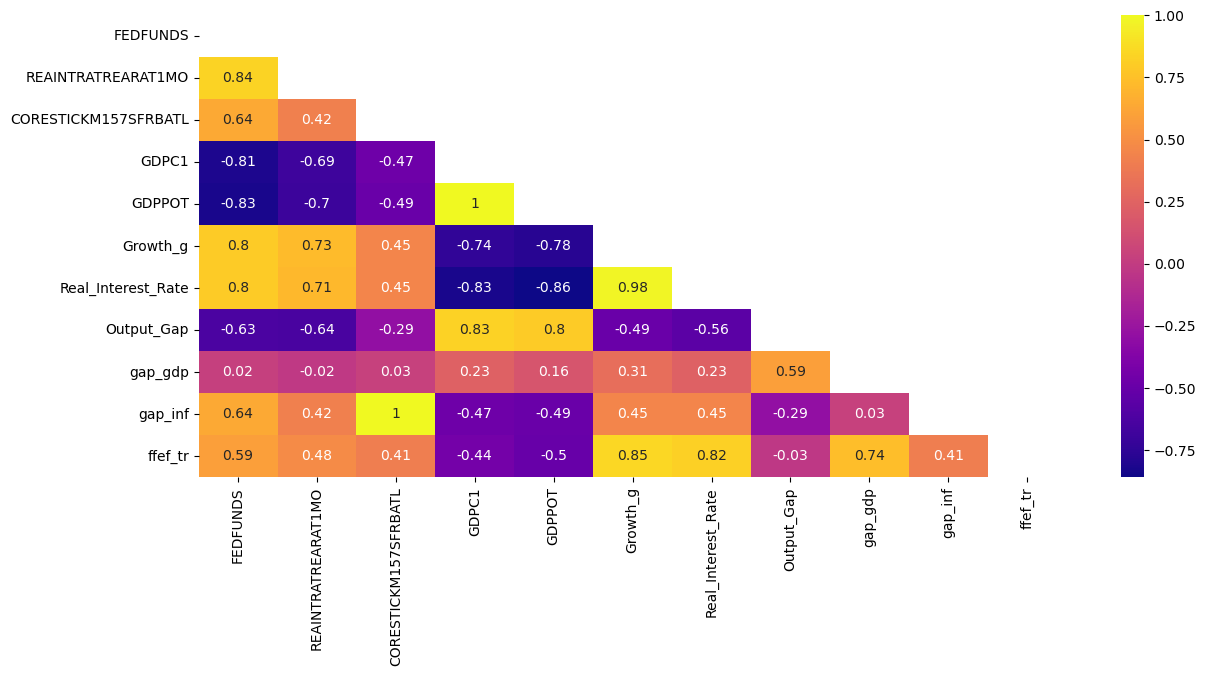

In [47]:
plt.figure(figsize=(14,6))
mask = np.zeros_like(f1_df.corr())
mask[np.triu_indices_from(mask)] = True
_p = sns.heatmap(f1_df.corr().round(2), annot=True, mask=mask, cmap="plasma")

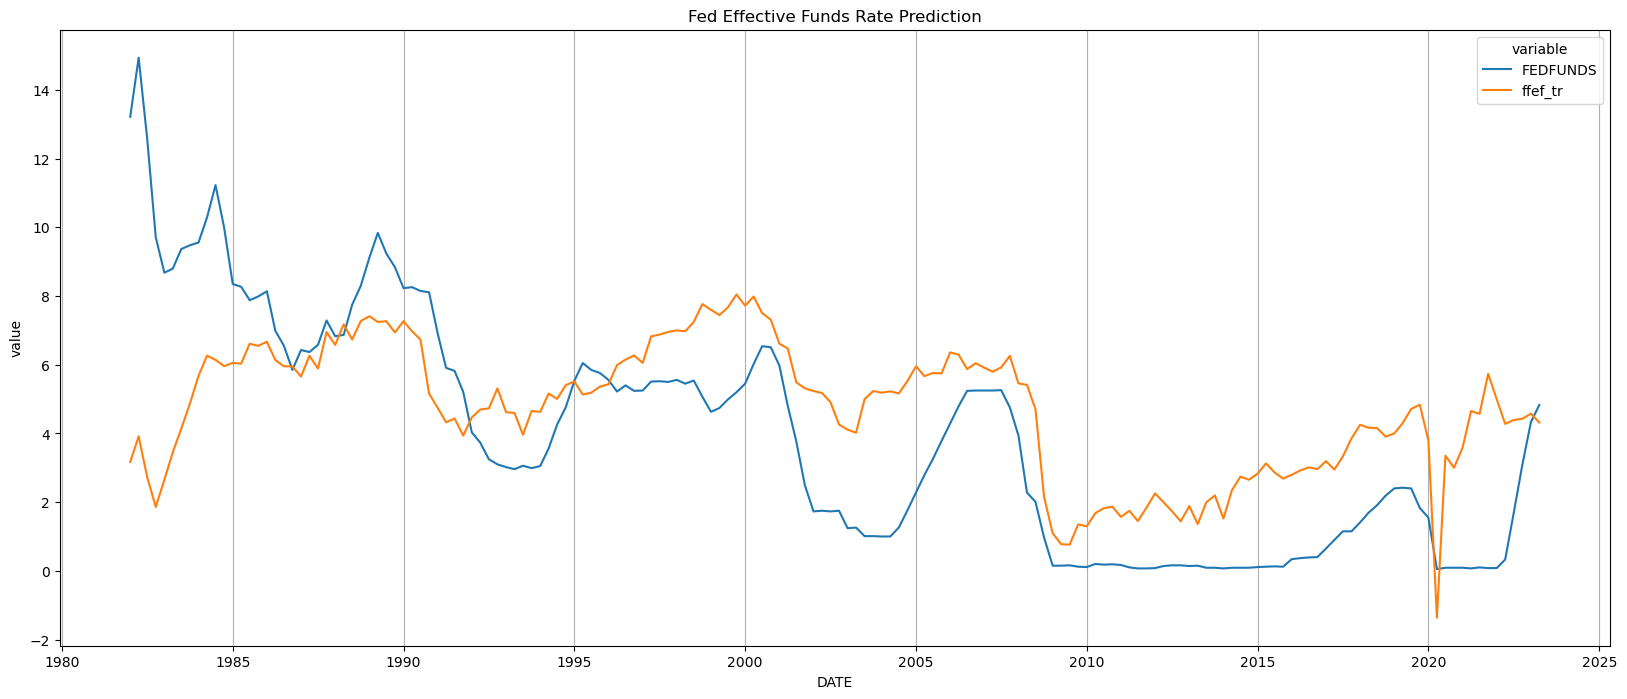

In [48]:
long_df = f1_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','FEDFUNDS','ffef_tr']].melt(id_vars=['DATE'])

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
sns.lineplot(data=long_df, x = 'DATE', y = 'value', hue='variable')
#ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

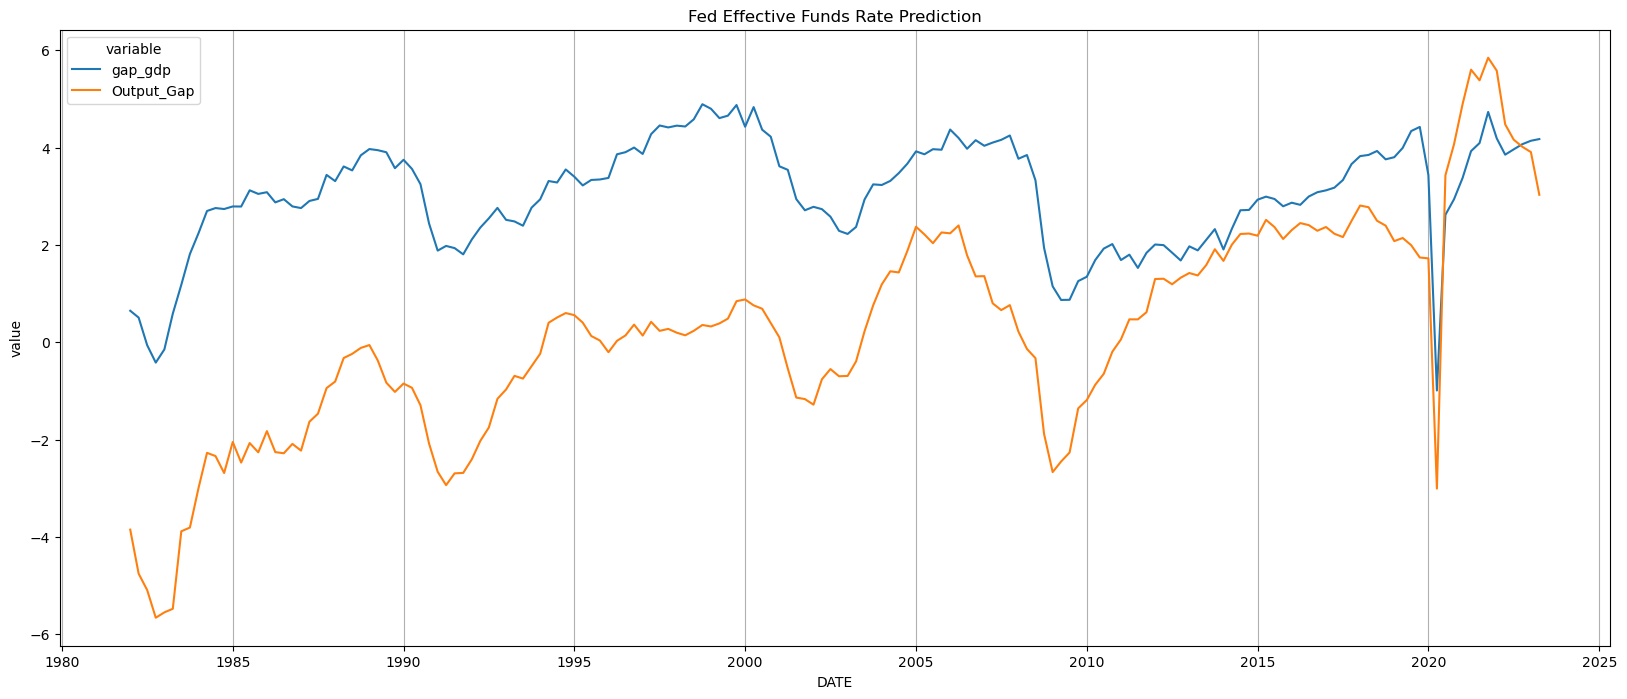

In [49]:
long_df = f1_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','gap_gdp','Output_Gap']].melt(id_vars=['DATE'])

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
sns.lineplot(data=long_df, x = 'DATE', y = 'value', hue='variable')
#ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

# Regression Models 

## Load Data

In [50]:
taylor_df = load_taylor()

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


In [51]:
test_df, train_df = time_split(taylor_df)

train_df:  (221, 7)
test_df:  (55, 7)


In [52]:
X_train = train_df[['gap_inf', 'gap_gdp']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['gap_inf', 'gap_gdp']]
y_test = test_df['FEDFUNDS']

In [53]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
#cat_columns_lst = ['LineOfBusiness','Segment','Type','pay_plan','Revenue_Band','cc_indicator','Service_Center']
num_columns_lst = ['gap_inf', 'gap_gdp']
#ohe_categories = list()

numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        #("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [55]:
pipe_lg = Pipeline(
    steps = [ ('preprocessor',preprocessor),  
             ('model',  LinearRegression()) ]
)
param_lg = {}


pipe_lasso = Pipeline( steps = [('preprocessor',preprocessor), ('model',Lasso())])
param_lasso = {'model__alpha': np.linspace(0.000001, 0.001, 50)}


pipe_knn = Pipeline(steps = [('preprocessor',preprocessor), ('model',KNeighborsRegressor())])
param_knn = {'model__n_neighbors': randint(3, 10)}


pipe_dt = Pipeline(steps = [('preprocessor',preprocessor), ('model',DecisionTreeRegressor())])
param_dt = {'model__max_leaf_nodes': randint(20, 150),
            'model__max_depth': randint(10, 40),
}

pipe_ada = Pipeline(
    steps = [('preprocessor',preprocessor), ('model',AdaBoostRegressor())]
)
param_ada = {'model__n_estimators': randint(100, 150)}


pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)
param_ltb = {
    'model__max_depth': randint(3, 20),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__verbose': [-1],
    'model__eval_metric': ['auc'],
}


pipe_xgb = Pipeline(
    steps = [('preprocessor',preprocessor), ('model',xgb.XGBRegressor(tree_method="hist", objective='binary:logistic'))]
)

param_xgb = {
    'model__max_depth': randint(3, 15),
    'model__num_leaves': randint(3, 15),
    'model__error_score' : ['raise'],
    'model__scale_pos_weight' : randint(3, 10)
}

In [56]:
pipe_dict = {'lg':pipe_lg, 'knn':pipe_knn, 'dt':pipe_dt, 'ada':pipe_ada, 'ltb':pipe_ltb, 'xgb':pipe_dt}
param_dict = {'lg':param_lg, 'knn':param_knn, 'dt':param_dt, 'ada':param_ada, 'ltb':param_ltb, 'xgb':param_dt}

#pipe_dict = {'ada':pipe_ada}
#param_dict = {'ada':param_ada}

#pipe_dict = {'ltb':pipe_ltb}
#param_dict = {'ltb':param_ltb}

#pipe_dict = {'xgb':pipe_dt}
#param_dict = {'xgb':param_dt}

lg ) Best Accuracy Score: -39.21688982924532 Parameters: {} {}
knn ) Best Accuracy Score: -1.3230404592742249 Parameters: {} {'model__n_neighbors': 3}
dt ) Best Accuracy Score: -0.8976817586828669 Parameters: {} {'model__max_depth': 21, 'model__max_leaf_nodes': 23}
ada ) Best Accuracy Score: -9.686347747750382 Parameters: {} {'model__n_estimators': 102}
ltb ) Best Accuracy Score: -1.4788094540892796 Parameters: {} {'model__eval_metric': 'auc', 'model__max_depth': 8, 'model__min_data_in_leaf': 19, 'model__num_leaves': 37, 'model__verbose': -1}
xgb ) Best Accuracy Score: -0.7627876797087992 Parameters: {} {'model__max_depth': 21, 'model__max_leaf_nodes': 23}


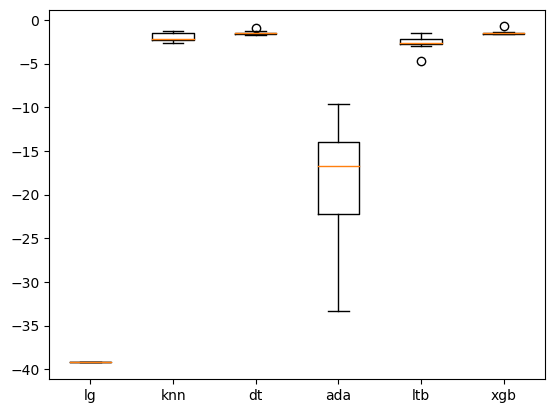

In [57]:
results_lst = []
model_dct = {}

for name, p in pipe_dict.items():
    cv = RandomizedSearchCV(estimator = p, param_distributions = param_dict[name]
                            , random_state=rand_int, scoring="r2")
    cv.fit(X_train, y_train)
    
    cv_results = cv.cv_results_['mean_test_score']
    results_lst.append(cv_results)
    
    model_dct[name] = cv
    print(name, ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)
    
plt.boxplot(results_lst, labels=pipe_dict.keys())
plt.show()

# Stats Model - Missery Indes

In [58]:
misery_df = load_misery()

t_df: (831, 3)
u_df: (909, 1)
misery_df: (831, 5)


In [59]:
train_df, test_df = time_split(misery_df)

train_df:  (665, 5)
test_df:  (166, 5)


In [100]:
misery_df.describe()

,FEDFUNDS,CPIAUCSL,UNRATE,CPIAUCSL_CH1,m_index
count,831.000000,831.000000,831.000000,831.000000,831.000000
mean,4.599037,128.531264,5.857762,3.977049,9.834811
std,3.598657,82.608377,1.666064,3.595957,3.864882
min,0.050000,26.710000,3.400000,-4.290000,3.900000
25%,1.780000,40.950000,4.600000,1.500000,7.000000
50%,4.160000,121.600000,5.600000,3.800000,9.800000
75%,6.245000,201.550000,6.900000,5.202500,11.600000
max,19.100000,307.481000,14.700000,24.169000,27.769000


In [61]:
X_train = train_df[['UNRATE', 'CPIAUCSL_CH1']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['UNRATE', 'CPIAUCSL_CH1']]
y_test = test_df['FEDFUNDS']

In [62]:
X_train_const = sm.add_constant(X_train)

In [63]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

In [101]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     161.9
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           5.66e-58
Time:                        23:33:07   Log-Likelihood:                -1620.6
No. Observations:                 665   AIC:                             3247.
Df Residuals:                     662   BIC:                             3261.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.5129      0.444      3.410      0.001       0.642       2.384
UNRATE           0.2770      0.074      3.739      0.000       0.132       0.423
CPIAUCSL_CH1     0.7119      0.043     16.680      0.000       0.628       0.796
==============================================================================
Omnibus:                       13.625   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.114
Skew:                           0.074   Prob(JB):                     5.81e-06
Kurtosis:                       3.921   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)
train_pred_ols

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
DATE,,,,,,
1954-07-01,3.169546,0.177219,2.821568,3.517524,-2.288204,8.627296
1954-08-01,3.175123,0.182117,2.817526,3.532719,-2.283249,8.633494
1954-09-01,3.145877,0.186565,2.779547,3.512207,-2.313074,8.604828
1954-10-01,2.928286,0.186710,2.561670,3.294902,-2.530684,8.387256
1954-11-01,2.931370,0.180923,2.576119,3.286621,-2.526849,8.389589
...,...,...,...,...,...,...
2009-07-01,1.090873,0.473162,0.161794,2.019951,-4.434445,6.616190
2009-08-01,1.862465,0.444145,0.990363,2.734568,-3.653558,7.378488
2009-09-01,2.080887,0.448109,1.201001,2.960772,-3.436372,7.598146


In [107]:
model_results(y_train, train_pred_ols['mean'], X_train.shape[0], 2 )

r-squared:  0.3285
adj r-squared 0.3275
mse:  7.6596
rmse:  2.7676


NameError: name 'predict' is not defined

In [67]:
X_test_const = sm.add_constant(X_test)

In [68]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)

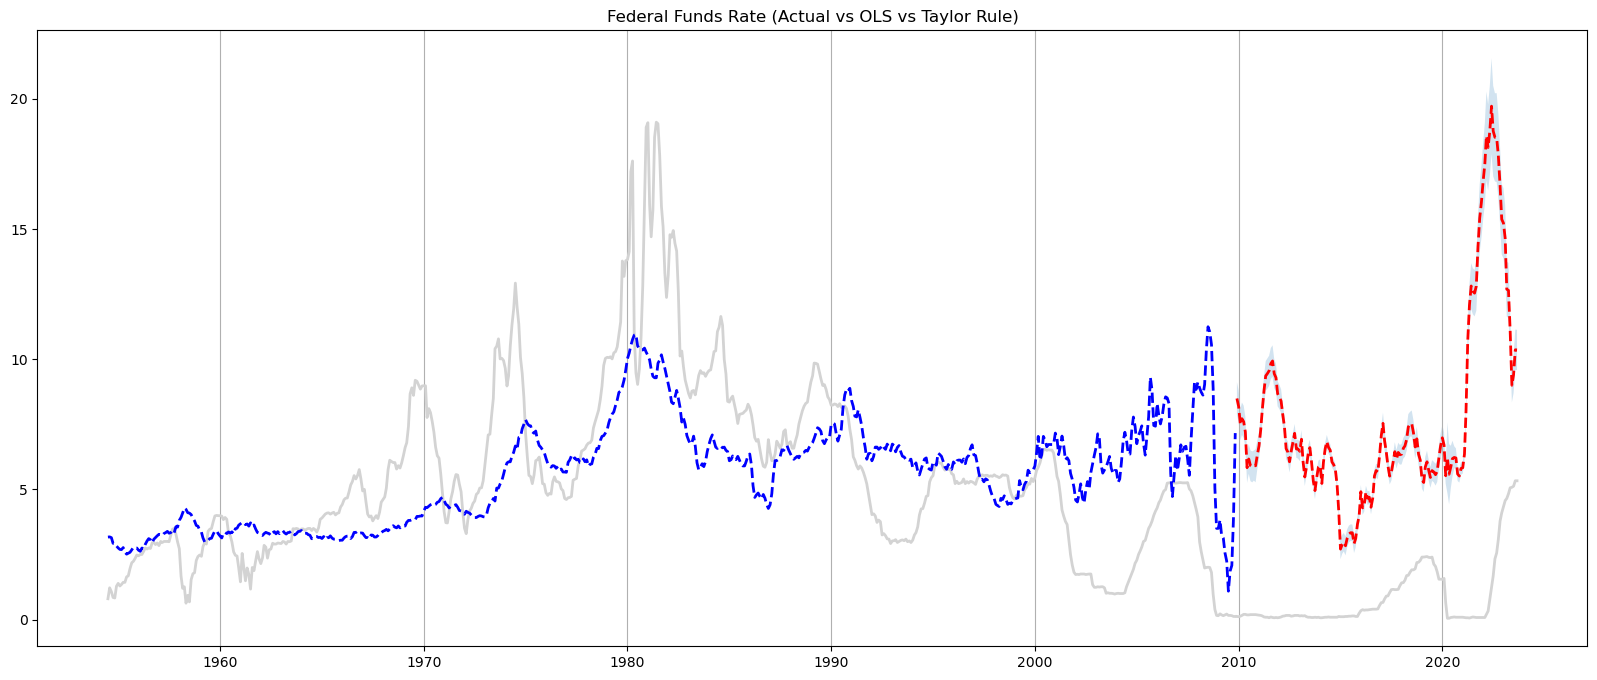

In [69]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(misery_df.index, misery_df['m_index'], 'orange', linestyle='--', linewidth=1)

#ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# Stats Model - Taylor Rule

In [70]:
taylor_df = load_taylor()

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


In [71]:
test_df, train_df = time_split(taylor_df)

train_df:  (221, 7)
test_df:  (55, 7)


## Training

In [72]:
X_train_const = sm.add_constant(X_train)
X_train_const

,const,UNRATE,CPIAUCSL_CH1
DATE,,,
1954-07-01,1.0,5.8,0.070
1954-08-01,1.0,6.0,0.000
1954-09-01,1.0,6.1,-0.080
1954-10-01,1.0,5.7,-0.230
1954-11-01,1.0,5.3,-0.070
...,...,...,...
2009-07-01,1.0,9.5,-4.290
2009-08-01,1.0,9.6,-3.245
2009-09-01,1.0,9.8,-3.016


In [73]:
y_train

DATE
1954-07-01    0.80
1954-08-01    1.22
1954-09-01    1.07
1954-10-01    0.85
1954-11-01    0.83
              ... 
2009-07-01    0.16
2009-08-01    0.16
2009-09-01    0.15
2009-10-01    0.12
2009-11-01    0.12
Name: FEDFUNDS, Length: 665, dtype: float64

In [74]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

In [102]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     161.9
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           5.66e-58
Time:                        23:33:37   Log-Likelihood:                -1620.6
No. Observations:                 665   AIC:                             3247.
Df Residuals:                     662   BIC:                             3261.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.5129      0.444      3.410      0.001       0.642       2.384
UNRATE           0.2770      0.074      3.739      0.000       0.132       0.423
CPIAUCSL_CH1     0.7119      0.043     16.680      0.000       0.628       0.796
==============================================================================
Omnibus:                       13.625   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.114
Skew:                           0.074   Prob(JB):                     5.81e-06
Kurtosis:                       3.921   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
train_pred = ols_result.predict(X_train_const)
train_pred

DATE
1954-07-01    3.169546
1954-08-01    3.175123
1954-09-01    3.145877
1954-10-01    2.928286
1954-11-01    2.931370
                ...   
2009-07-01    1.090873
2009-08-01    1.862465
2009-09-01    2.080887
2009-10-01    3.937288
2009-11-01    7.160631
Length: 665, dtype: float64

In [77]:
t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)
train_pred_ols

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
DATE,,,,,,
1954-07-01,3.169546,0.177219,2.821568,3.517524,-2.288204,8.627296
1954-08-01,3.175123,0.182117,2.817526,3.532719,-2.283249,8.633494
1954-09-01,3.145877,0.186565,2.779547,3.512207,-2.313074,8.604828
1954-10-01,2.928286,0.186710,2.561670,3.294902,-2.530684,8.387256
1954-11-01,2.931370,0.180923,2.576119,3.286621,-2.526849,8.389589
...,...,...,...,...,...,...
2009-07-01,1.090873,0.473162,0.161794,2.019951,-4.434445,6.616190
2009-08-01,1.862465,0.444145,0.990363,2.734568,-3.653558,7.378488
2009-09-01,2.080887,0.448109,1.201001,2.960772,-3.436372,7.598146


In [109]:
model_results(y_train, train_pred_ols['mean'], X_train.shape[0], 2 )

r-squared:  0.3285
adj r-squared 0.3275
mse:  7.6596
rmse:  2.7676
rmse:  2.7676072624402828


## Test

In [79]:
X_test_const = sm.add_constant(X_test)
#X_test_const

test_pred_ols = ols_result.predict(X_test_const)
test_pred_ols

In [80]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
#test_pred_ols

In [81]:
model_results(y_test, test_pred_ols['mean'], X_train.shape[0], 2 )

r-squared:  -35.4638
adj r-squared -35.5188
mse:  59.7109
rmse:  7.7273


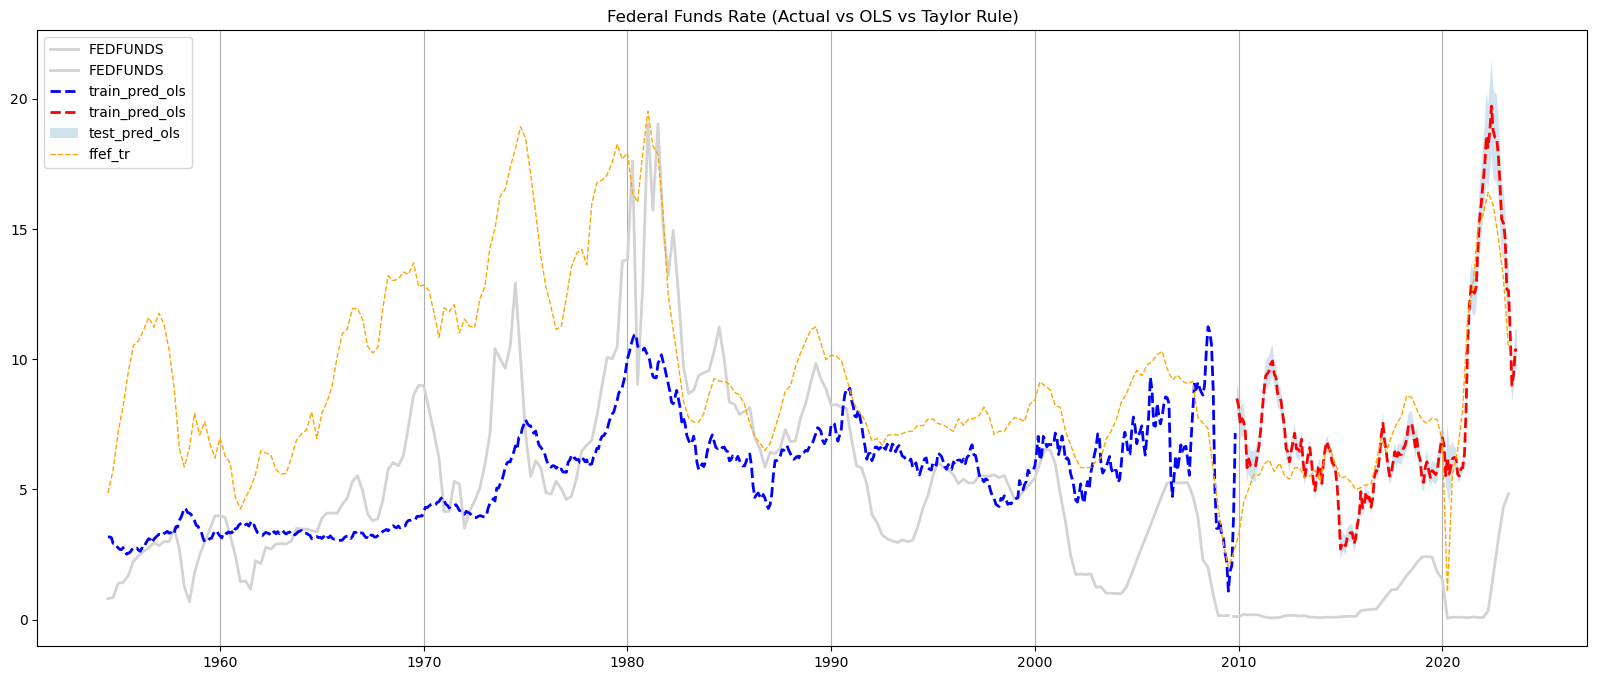

In [82]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# Linear Regression

In [83]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.32849740699914753

In [84]:
#reg.get_params()

In [85]:
train_pred2 = reg.predict(X_train)

In [86]:
model_results(y_train, train_pred2, X_train.shape[0], 2 )

r-squared:  0.3285
adj r-squared 0.3275
mse:  7.6596
rmse:  2.7676


# LGBM

In [87]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train, y_train)
train_pred3 = ltb_model.predict(X_train, pred_contrib=False, raw_score=False)

<Axes: >

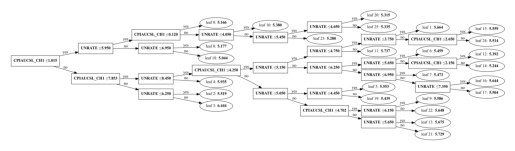

In [88]:
#ltb_model.create_tree_digraph()

ltb.plot_tree(ltb_model)

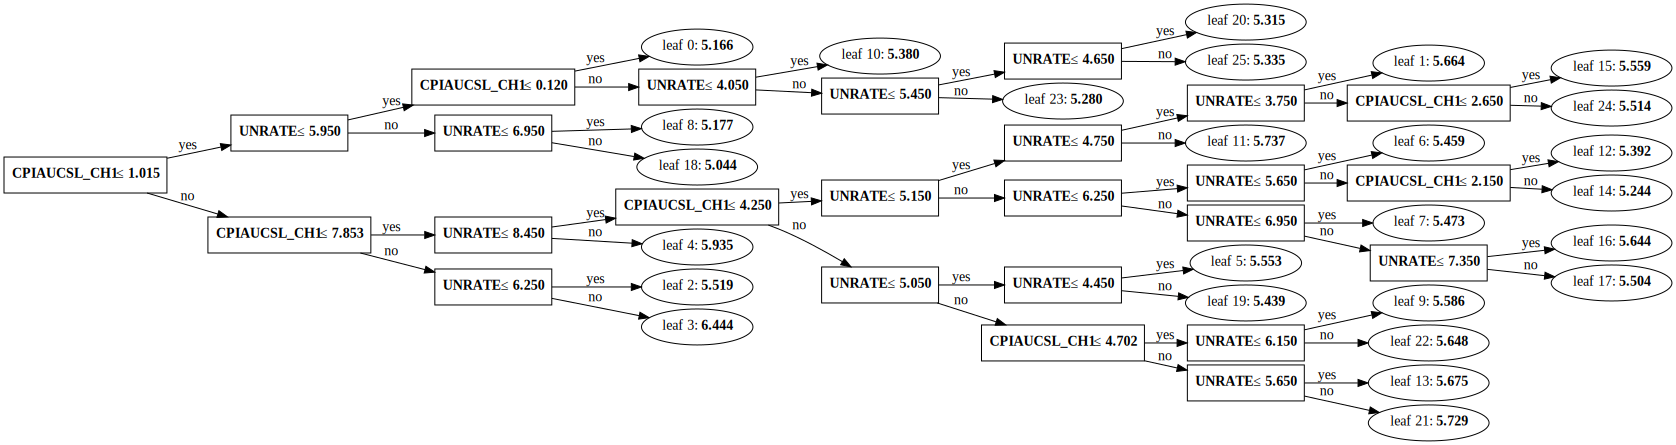

In [89]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

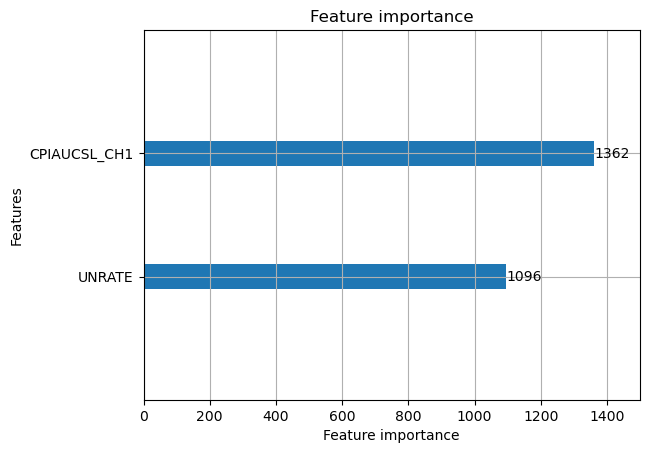

In [90]:
ltb.plot_importance(ltb_model)

In [91]:
#ltb.plot_metric(ltb_model, metric=['rmse'])

In [92]:
model_results(y_train, train_pred3, X_train.shape[0], 2 )

r-squared:  0.7868
adj r-squared 0.7865
mse:  2.4317
rmse:  1.5594


# XGB

In [93]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train, y_train)
train_pred4 = xgb_model.predict(X_train)
xgb_model.score(X_train, y_train)

0.9575132804436436

In [94]:
model_results(y_train, train_pred4, X_train.shape[0], 2 )

r-squared:  0.9575
adj r-squared 0.9574
mse:  0.4846
rmse:  0.6962


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

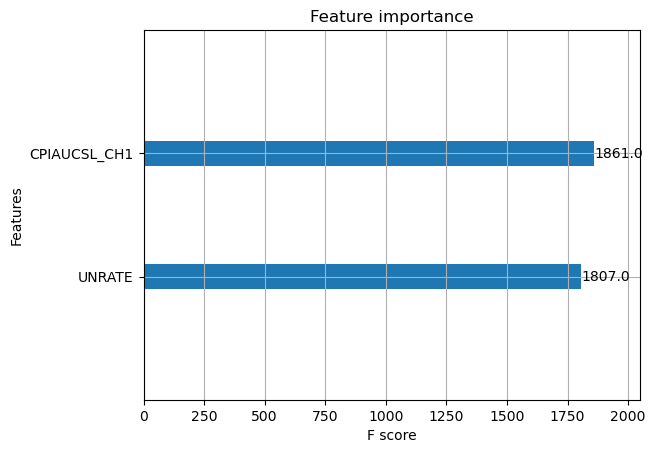

In [95]:
xgb.plot_importance(xgb_model)

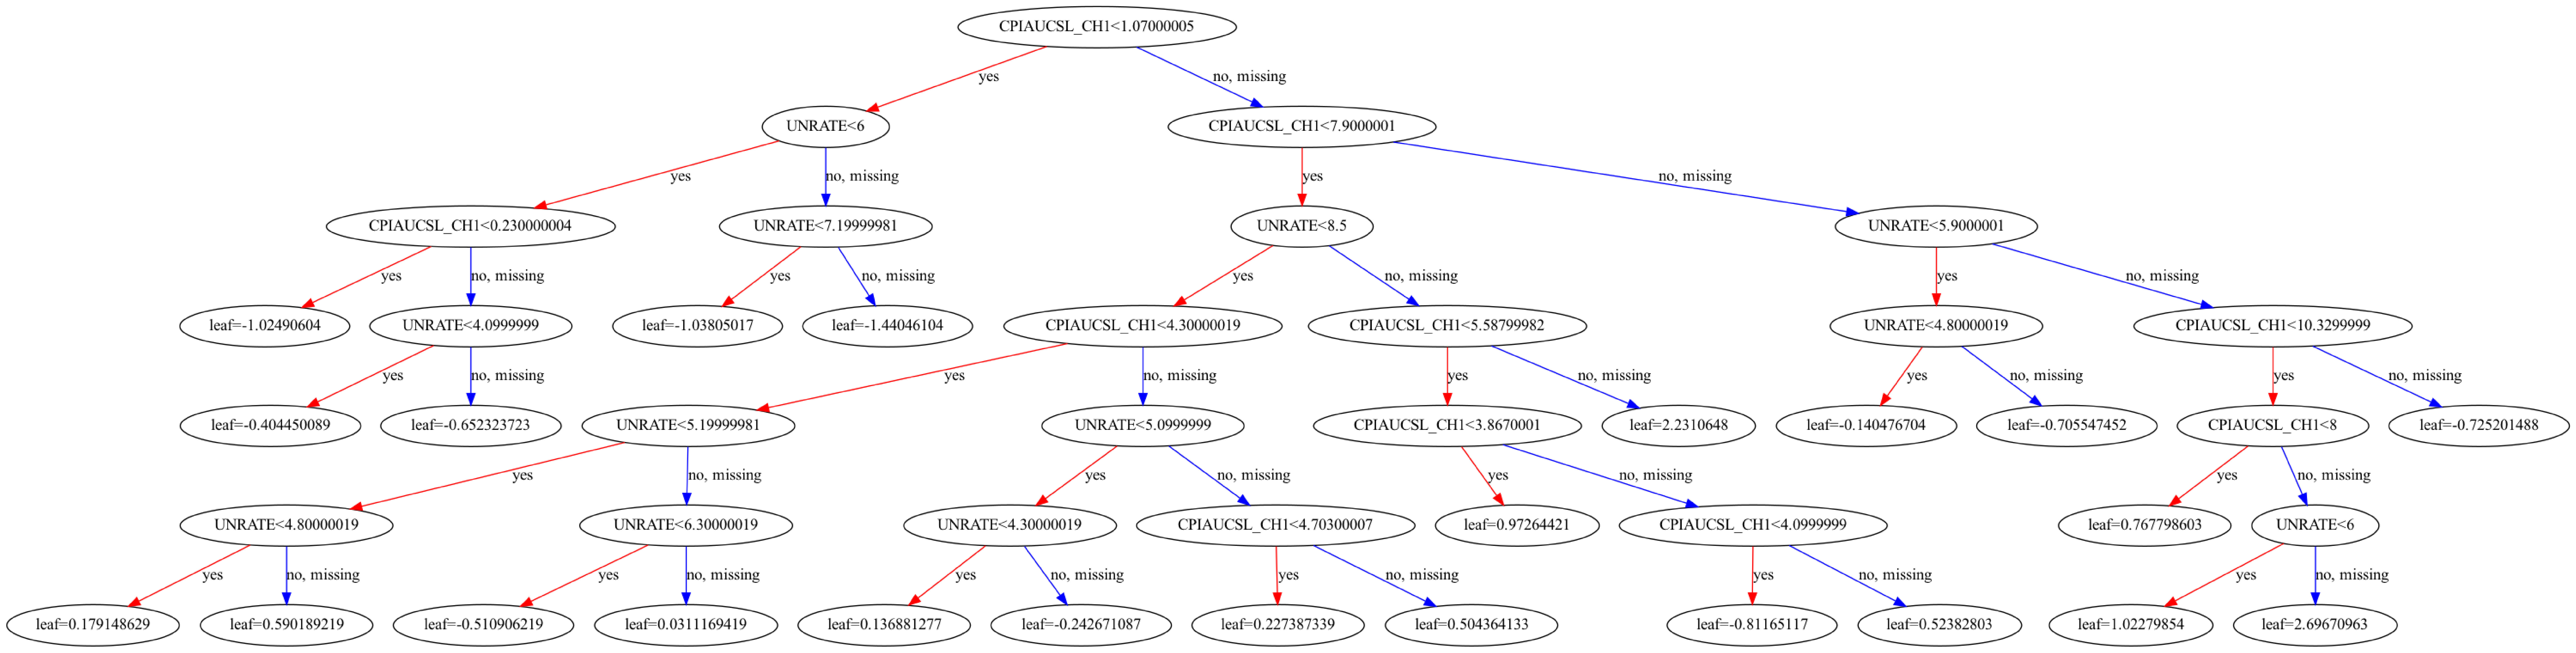

In [96]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

In [97]:
AdaBoostRegressor

ada_model = AdaBoostRegressor().fit(X_train, y_train)
train_pred5 = ada_model.predict(X_train)

In [98]:
model_results(y_train, train_pred5, X_train.shape[0], 2 )

r-squared:  0.588
adj r-squared 0.5874
mse:  4.6996
rmse:  2.1679
